# Converting Data from Raster to Tabular (Geometry) format

### Import the libraries

In [7]:
import pandas
import osmnx
import geopandas 
import rioxarray
import xarray
import datashader as ds
import contextily as cx
from shapely import geometry
import matplotlib.pyplot as plt
import folium

In [14]:
import warnings
warnings.filterwarnings(action='ignore')

### Download Geopackage

In [2]:
# URL for the geopackage
url = ("https://jeodpp.jrc.ec.europa.eu/ftp/"\
       "jrc-opendata/GHSL/"\
       "GHS_FUA_UCDB2015_GLOBE_R2019A/V1-0/"\
       "GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.zip"
      )
url

'https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_FUA_UCDB2015_GLOBE_R2019A/V1-0/GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.zip'

### Visualize the map

In [3]:
# Visualize the Map for Sao Paulo
p = f"zip+{url}!GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.gpkg"
fuas = geopandas.read_file(p)
sao_paulo = fuas.query("eFUA_name == 'São Paulo'").to_crs("EPSG:4326")

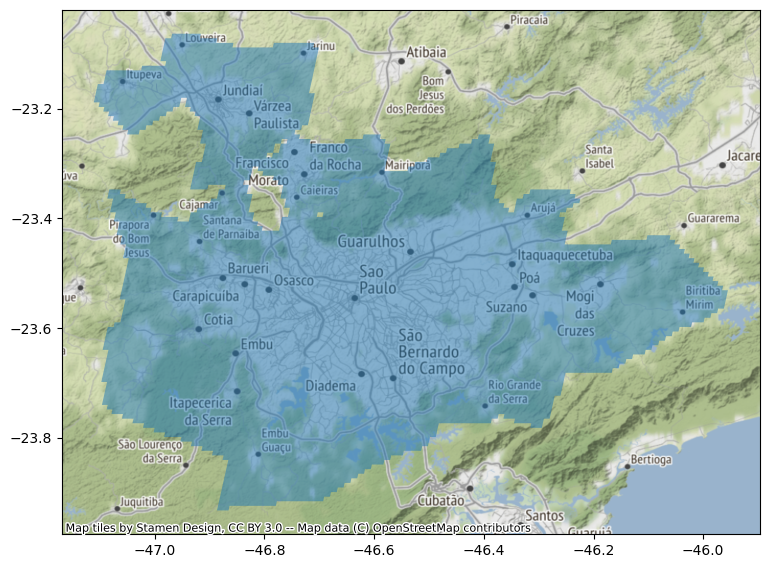

In [4]:
ax = sao_paulo.plot(alpha=0.5, figsize=(9, 9))
cx.add_basemap(ax, crs=sao_paulo.crs);

### Download the population data

In [5]:
url = ("https://cidportal.jrc.ec.europa.eu/ftp/"\
       "jrc-opendata/GHSL/GHS_POP_MT_GLOBE_R2019A/"\
       "GHS_POP_E2015_GLOBE_R2019A_54009_250/V1-0/"\
       "tiles/"\
       "GHS_POP_E2015_GLOBE_R2019A_54009_250_V1_0_13_11.zip"
      )
url

'https://cidportal.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_MT_GLOBE_R2019A/GHS_POP_E2015_GLOBE_R2019A_54009_250/V1-0/tiles/GHS_POP_E2015_GLOBE_R2019A_54009_250_V1_0_13_11.zip'

In [6]:
# Population data in raster format
%%time
p = f"zip+{url}!GHS_POP_E2015_GLOBE_R2019A_54009_250_V1_0_13_11.tif"
ghsl = rioxarray.open_rasterio(p)
ghsl

CPU times: user 35.6 ms, sys: 4.12 ms, total: 39.8 ms
Wall time: 7.12 s


<xarray.DataArray (band: 1, y: 4000, x: 4000)>
[16000000 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -5.041e+06 -5.041e+06 ... -4.041e+06 -4.041e+06
  * y            (y) float64 -2e+06 -2e+06 -2.001e+06 ... -3e+06 -3e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -200.0
    scale_factor:   1.0
    add_offset:     0.0

### Visualize the population on raster data

In [8]:
cvs = ds.Canvas(plot_width=600, plot_height=600)
agg = cvs.raster(ghsl.where(ghsl>0).sel(band=1))

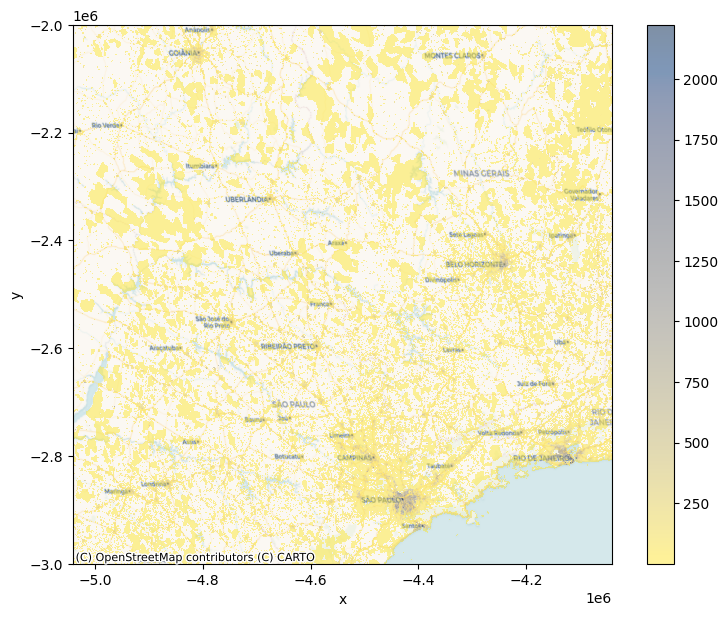

In [9]:
f, ax = plt.subplots(1, figsize=(9, 7))
agg.plot.imshow(ax=ax, alpha=0.5, cmap="cividis_r")
cx.add_basemap(
    ax, 
    crs=ghsl.rio.crs, 
    zorder=-1, 
    source=cx.providers.CartoDB.Voyager
)


In [10]:
# Clip the data for Sao Paulo
ghsl_sp = ghsl.rio.clip(sao_paulo.to_crs(ghsl.rio.crs).geometry.iloc[0])
ghsl_sp

/home/thulasiram/miniconda3/envs/geopy/lib/python3.9/site-packages/rasterio/features.py:290: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):


<xarray.DataArray (band: 1, y: 416, x: 468)>
array([[[-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        ...,
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -4.482e+06 -4.482e+06 ... -4.365e+06 -4.365e+06
  * y            (y) float64 -2.822e+06 -2.822e+06 ... -2.926e+06 -2.926e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     -200.0

out_p = "../data/ghsl_sao_paulo.tif"
! rm $out_p
ghsl_sp.rio.to_raster(out_p)

### Convert Raster to geometry

In [15]:
# Read the raster data
surface = xarray.open_rasterio("../data/ghsl_sao_paulo.tif")

In [16]:
# Convert raster to geometry
t_surface = surface.to_series()

In [17]:
t_surface.head()

band  y           x         
1     -2822125.0  -4481875.0   -200.0
                  -4481625.0   -200.0
                  -4481375.0   -200.0
                  -4481125.0   -200.0
                  -4480875.0   -200.0
dtype: float32

In [18]:
t_surface = t_surface.reset_index().rename(columns={0: "Value"})

In [19]:
t_surface.query("Value > 1000").info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7734 entries, 3785 to 181296
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   band    7734 non-null   int64  
 1   y       7734 non-null   float64
 2   x       7734 non-null   float64
 3   Value   7734 non-null   float32
dtypes: float32(1), float64(2), int64(1)
memory usage: 271.9 KB


In [26]:
type(t_surface)

pandas.core.frame.DataFrame

In [20]:
# Calculate the polygon based on resolution values
def row2cell(row, res_xy):
    res_x, res_y = res_xy  # Extract resolution for each dimension
    # XY Coordinates are centered on the pixel
    minX = row["x"] - (res_x / 2)
    maxX = row["x"] + (res_x / 2)
    minY = row["y"] + (res_y / 2)
    maxY = row["y"] - (res_y / 2)
    poly = geometry.box(
        minX, minY, maxX, maxY
    )  # Build squared polygon
    return poly

In [21]:
# Get the polygons
max_polys = (
    t_surface.query(
        "Value > 1000"
    )  # Keep only cells with more than 1k people
    .apply(  # Build polygons for selected cells
        row2cell, res_xy=surface.attrs["res"], axis=1
    )
    .pipe(  # Pipe result from apply to convert into a GeoSeries
        geopandas.GeoSeries, crs=surface.attrs["crs"]
    )
)

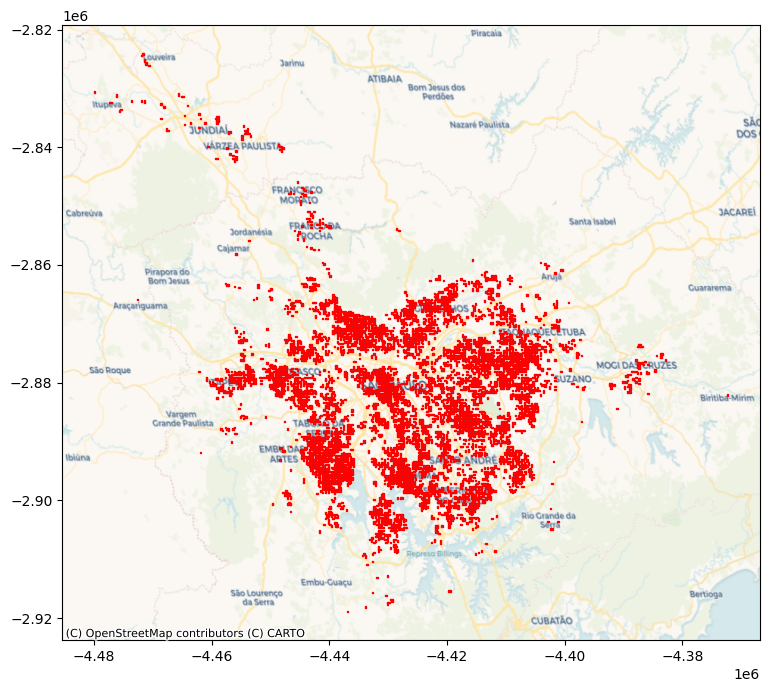

In [29]:
# Plot polygons on the map
ax = max_polys.plot(edgecolor="red", figsize=(9, 9))
# Add basemap
cx.add_basemap(
    ax, crs=surface.attrs["crs"], source=cx.providers.CartoDB.Voyager
)

### Convert Geometry to Raster

In [30]:
new_da = xarray.DataArray.from_series(
    t_surface.set_index(["band", "y", "x"])["Value"]
)
new_da

<xarray.DataArray 'Value' (band: 1, y: 416, x: 468)>
array([[[-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        ...,
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.]]], dtype=float32)
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 -2.926e+06 -2.926e+06 ... -2.822e+06 -2.822e+06
  * x        (x) float64 -4.482e+06 -4.482e+06 ... -4.365e+06 -4.365e+06